# 1 IMPORTS

In [188]:
import pandas as pd
import seaborn as sns
import inflection

from tabulate import tabulate
from IPython.display import Image
from pandas_profiling import ProfileReport
from pycorrcat.pycorrcat import plot_corr, corr_matrix
import matplotlib.pyplot as plt

## 1.1 Definitions 

In [2]:
# Standard font for plots
def std_font(ax1, title, xlabel, ylabel):
    ax1.set_title(title, loc='left', fontdict={'fontsize': 18}, pad=20)
    ax1.set_xlabel(xlabel, fontdict={'fontsize': 12, 'style': 'italic'})
    ax1.set_ylabel(ylabel, fontdict={'fontsize': 12, 'style': 'italic'})
    return None

## 1.2 Loading Data

In [3]:
# coletando os dados e salvando localmente
url = 'https://raw.githubusercontent.com/sthemonica/alura-voz/main/Dados/Telco-Customer-Churn.json'
df_raw = pd.read_json(url)
df_raw.to_json('../data/customers.json')


# 2 DATA DESCRIPTION

## 2.1 Data Preview

Após a importação dos dados, verificamos que há informações aninhadas em formato json. Portanto, para acessar esses dados e termos o nosso dataframe definitivo, utilizaremos ferramentas que serão mostradas nas próximas sessões.

In [4]:
df_raw.head(3)

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## 2.2 Data Format and Types

In [5]:
# coletando informacoes dos jsons
columns = ['customer', 'phone', 'internet', 'account']
for column in columns:
    df_temp = pd.json_normalize(data=df_raw[column], sep='_')
    df_raw = pd.concat([df_raw, df_temp], axis=1)

# removendo colunas duplicadas
df_raw = df_raw.loc[:,~df_raw.columns.duplicated()]

# padronizando os headers para snake case
cols_snake = list( map( lambda x: inflection.underscore( x ), df_raw.columns ) )
df_raw.columns = cols_snake

# removendo as colunas com os formatos json
df_raw.drop(columns=['customer', 'phone', 'internet', 'account'],inplace=True)

# transformando valores vazios e ausentes em NA
df_raw = df_raw.mask(df_raw == ' ').mask(df_raw == '')


In [6]:
# removendo 11 linhas que estão com valores vazios em charges_total para converter em float
df_raw.dropna(subset=['charges_total'], inplace=True)
df_raw['charges_total'] = df_raw['charges_total'].astype('float')

In [7]:
df_raw.head(3)

,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,charges_monthly,charges_total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7256 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7256 non-null   object 
 1   churn              7032 non-null   object 
 2   gender             7256 non-null   object 
 3   senior_citizen     7256 non-null   int64  
 4   partner            7256 non-null   object 
 5   dependents         7256 non-null   object 
 6   tenure             7256 non-null   int64  
 7   phone_service      7256 non-null   object 
 8   multiple_lines     7256 non-null   object 
 9   internet_service   7256 non-null   object 
 10  online_security    7256 non-null   object 
 11  online_backup      7256 non-null   object 
 12  device_protection  7256 non-null   object 
 13  tech_support       7256 non-null   object 
 14  streaming_tv       7256 non-null   object 
 15  streaming_movies   7256 non-null   object 
 16  contract           7256 

## 2.3 NA Checking and Treatment

Agora que conseguimos ter acesso às informações dos jsons aninhados, faremos o tratamento de valores nulos/faltantes.

In [9]:
df_raw.isna().sum()

customer_id            0
churn                224
gender                 0
senior_citizen         0
partner                0
dependents             0
tenure                 0
phone_service          0
multiple_lines         0
internet_service       0
online_security        0
online_backup          0
device_protection      0
tech_support           0
streaming_tv           0
streaming_movies       0
contract               0
paperless_billing      0
payment_method         0
charges_monthly        0
charges_total          0
dtype: int64

In [10]:
# deletando as linhas com valores nulos em churn. Como é nossa variável resposta, não
# temos como inferir valores.
df_raw.dropna(inplace=True)

In [11]:
df_raw.isna().sum()

customer_id          0
churn                0
gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
charges_monthly      0
charges_total        0
dtype: int64

## 2.4 Discriptive Statistics

Nesta seção faremos uma rápida análise estatística para identificar se temos valores que precisam de uma maior atenção (valores negativos, outliers, erros de digitação, etc).

### Numerical Attributes

In [12]:
num_att = df_raw.select_dtypes(['int64', 'float64'])
# getting skew
skew = pd.DataFrame(num_att.apply(lambda x: x.skew())).round(2).T
skew.rename(index={0: 'skew'}, inplace=True)

# getting kurtosis
kurtosis = pd.DataFrame(num_att.apply(lambda x: x.kurtosis())).round(2).T
kurtosis.rename(index={0: 'kurtosis'}, inplace=True)

# numerical features 
describe = df_raw.describe().round(2)
m = pd.concat([describe, skew, kurtosis], axis=0)
m

,senior_citizen,tenure,charges_monthly,charges_total
count,7032.00,7032.00,7032.00,7032.00
mean,0.16,32.42,64.80,2283.30
std,0.37,24.55,30.09,2266.77
min,0.00,1.00,18.25,18.80
25%,0.00,9.00,35.59,401.45
50%,0.00,29.00,70.35,1397.48
75%,0.00,55.00,89.86,3794.74
max,1.00,72.00,118.75,8684.80
skew,1.83,0.24,-0.22,0.96
kurtosis,1.35,-1.39,-1.26,-0.23


### Categorical Attributes

Observamos nesta seção que temos muitas variáveis categóricas com uma baixa quantidade de valores únicos. Nos próximos snippets iremos observar a possibilidade de simplificar estas features.

In [13]:
cat_att = df_raw.select_dtypes(exclude=['int64', 'float64'])
cat_att.apply( lambda x: x.unique().shape[0] )

customer_id          7032
churn                   2
gender                  2
partner                 2
dependents              2
phone_service           2
multiple_lines          3
internet_service        3
online_security         3
online_backup           3
device_protection       3
tech_support            3
streaming_tv            3
streaming_movies        3
contract                3
paperless_billing       2
payment_method          4
dtype: int64

In [14]:
for column in df_raw.columns:
    print(column, ': ',df_raw[column].unique())

customer_id :  ['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
churn :  ['No' 'Yes']
gender :  ['Female' 'Male']
senior_citizen :  [0 1]
partner :  ['Yes' 'No']
dependents :  ['Yes' 'No']
tenure :  [ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 37 49 66 67
 20 43 59 12 27  2 25 29 14 35 64 39 40 11  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 31 36 17 18 51 38 42]
phone_service :  ['Yes' 'No']
multiple_lines :  ['No' 'Yes' 'No phone service']
internet_service :  ['DSL' 'Fiber optic' 'No']
online_security :  ['No' 'Yes' 'No internet service']
online_backup :  ['Yes' 'No' 'No internet service']
device_protection :  ['No' 'Yes' 'No internet service']
tech_support :  ['Yes' 'No' 'No internet service']
streaming_tv :  ['Yes' 'No' 'No internet service']
streaming_movies :  ['No' 'Yes' 'No internet service']
contract :  ['One year' 'Month-to-month' 'Two year']
paperless_billing :  ['Yes' 'No']
payment_meth

Para as features numéricas, não identificamos valores discrepantes ou possivelmente errados. Porém, para as features categóricas, observamos que algumas features apresentam valores redundantes ('No' e 'No xxxx service'). Para esse primeiro ciclo CRISP-DM/DS, iremos considerar que esses dois valores transmitem a mesma informação e iremos padronizá-los na seção 5.

# 3 DATAFRAME FILTERING

In [15]:
df_clean = df_raw.copy()

## 3.1 Line Filtering

## 3.2 Column Selection

# 4 QUESTIONS & HYPOTHESIS

## 4.1 Entendimento do negócio

Nesta seção iremos entender um pouco sobre o negócio, descobrindo as métricas que norteiam o ramo de telecomunicações. Também iremos formular hipóteses para posteriormente, na seção 6.2, confirmar ou não as hipóteses levantadas, gerando também insights importantes para a empresa.

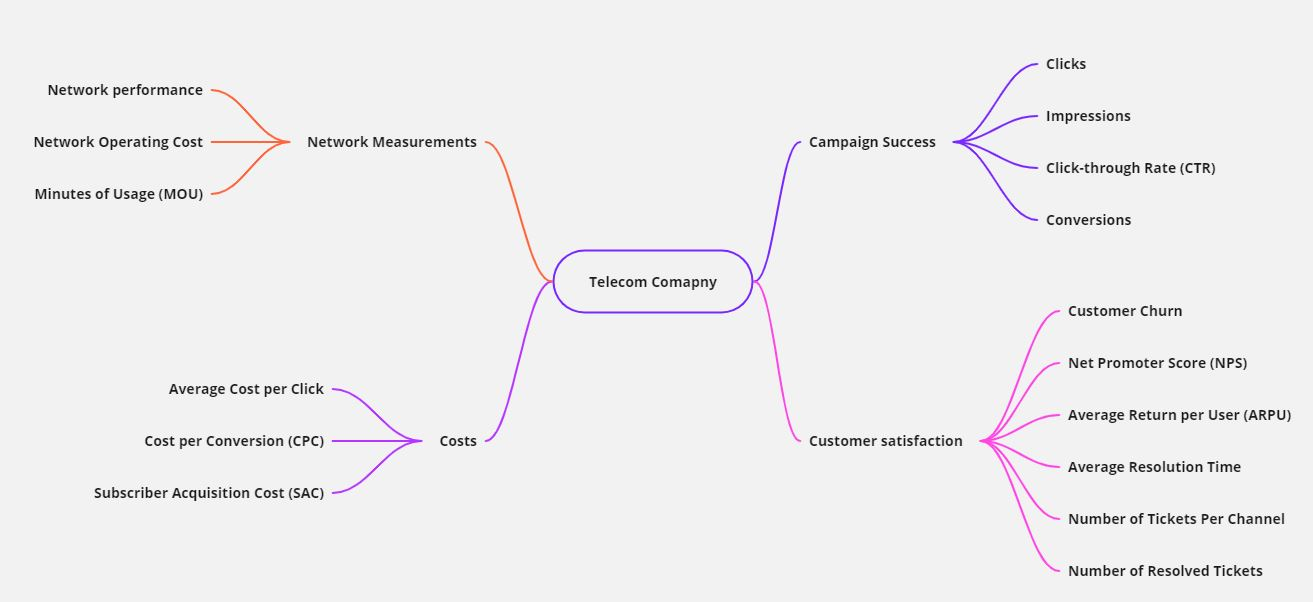

In [16]:
Image( '../images/metrics.JPG' )

Algumas métricas do ramo de telecomunicações:

- **Clicks:** Medir quantos clientes clicam em um CTA em uma determinada página da web, um link de e-mail ou um anúncio digital ainda é uma das melhores maneiras de ter uma ideia do sucesso de uma campanha de marketing

- **Impressions:** Impressões referem-se à frequência com que seu anúncio foi exibido em uma determinada plataforma, canal ou rede de publicidade.

- **Average Cost per Click:** Custo total de seus cliques pelo número total de cliques

- **Cost per Conversion (CPC):** O custo total pago por um anúncio em relação ao sucesso em atingir o objetivo desse anúncio

- **Click-through Rate (CTR):** A CTR é um KPI relacionado a cliques e impressões, traduzindo cliques em tendências, em vez de deixá-los como números agregados.

- **Conversions:** As conversões se baseiam em cliques e CTRs, exigindo que os usuários ajam assim que interagirem com seu anúncio

- **Customer Churn**

- **Network performance:** Medem fatores como disponibilidade de rede, acessibilidade, capacidade e utilização, velocidade e taxa de transferência.

- **Network Operating Cost:** Infraestrutura para manter, e muitas coisas podem aumentar seu custo, incluindo atualizações de TI, manutenção de aplicativos, segurança, suporte técnico ao cliente, cobre, fibra, micro-ondas e assim por diante.

- **Net Promoter Score (NPS):** Mede a probabilidade de um cliente recomendar sua empresa para familiares, amigos ou colegas.

- **Average Resolution Time:** É o tempo médio que os agentes de suporte levam para resolver todos os tickets abertos em um período de tempo definido.

- **Number of Tickets Per Channel:** Medidas suportam o volume de tickets ao longo do tempo

- **Number of Resolved Tickets:** Quantos tickets um agente ou equipe de atendimento ao cliente resolveu dentro de um prazo definido

- **Average revenue per user (ARPU):** Mede a receita média que uma empresa gera por usuário em um determinado período.

- **Minutes of Usage (MOU):** É o tempo total em minutos, usado por um cliente em seu celular, dentro de um determinado período de tempo.

- **Subscriber Acquisition Cost (SAC):** É uma medida usada para descobrir o custo médio total de adicionar um novo assinante à lista.


## 4.2 Hipóteses

Após o entendimento das métricas do negócio, iremos utilizar o nosso dataset para responder as hipóteses que seguem:

**1.** Quanto mais tempo de contrato o cliente tiver, menor a taxa de churn.

**2.** Mulheres tem maior probabilidade de entrar em churn.

**3.** Clientes com dependentes tendem a ter menor taxa de churn

**4.** Quanto maior o tempo de contrato, menor a taxa de churn

**5.** A maioria dos clientes que entraram em churn não tinham suporte técnico

**6.** O meio de recebimento da fatura não tem influência na taxa de churn

**7.** Clientes que tem assinatura de tv a cabo tem menores taxas de churn

**8.** Clientes com gasto diário de mais de $3 tendem a ter maior taxa de churn


# 5 FEATURE ENGINEERING

In [17]:
# ------- CONFERIR A EFETIVIDADE DESSA MODIFICAÇÃO NOS PRÓXIMOS CICLOS --------
# transformando os valores "no xxxx service em no"
for column in df_clean.columns[8:16]:
    df_clean.loc[:,column] = df_clean[column].apply(lambda x: 0 if 'No' in x else 1)
# -----------------------------------------------------------------------------

# transformando a variável churn em int
df_clean.loc[:,'churn'] = df_clean['churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# transformando a variável partner em int
df_clean.loc[:,'partner'] = df_clean['partner'].apply(lambda x: 1 if x == 'Yes' else 0)

# transformando a variável dependents em int
df_clean.loc[:,'dependents'] = df_clean['dependents'].apply(lambda x: 1 if x == 'Yes' else 0)

# transformando a variável phone_service em int
df_clean.loc[:,'phone_service'] = df_clean['phone_service'].apply(lambda x: 1 if x == 'Yes' else 0)

# transformando a variável paperless_billing em int
df_clean.loc[:,'paperless_billing'] = df_clean['paperless_billing'].apply(lambda x: 1 if x == 'Yes' else 0)

# criando feature de gasto diário partindo do charges_total
df_clean.insert(loc=18, column='daily_charge', value=df_clean['charges_total']/(df_clean['tenure']*30))

# 6 EXPLORATORY DATA ANALYSIS

Como temos muitas features, utilizei o pandas profiling para gerar um relatório estatístico de maneira mais prática e rápida, para análise.

In [19]:
# utilizando o profile report para salvar as análises univariadas em html
profile = ProfileReport( df_clean )
profile.to_file( '../general_statistics.html' )

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 6.1 Univariate Analysis

### 6.1.1 Response Variable

Como mostrado no histograma abaixo, observamos que há um desbalanceamento na variável resposta. Em algoritmos de classificação, este é um ponto importante a ser observado, pois pode influenciar negativamente o desempenho do nosso modelo.

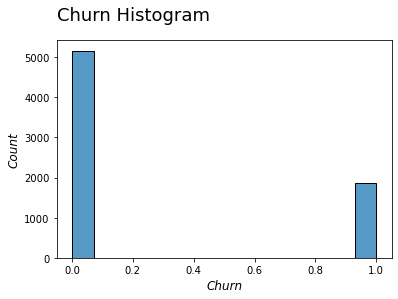

In [20]:
ax1 = sns.histplot(data=df_clean, x='churn')
std_font(ax1, 'Churn Histogram', 'Churn', 'Count')

### 6.1.2 Numerical Variable

In [30]:
num_att = df_clean.select_dtypes(['int64', 'float64'])

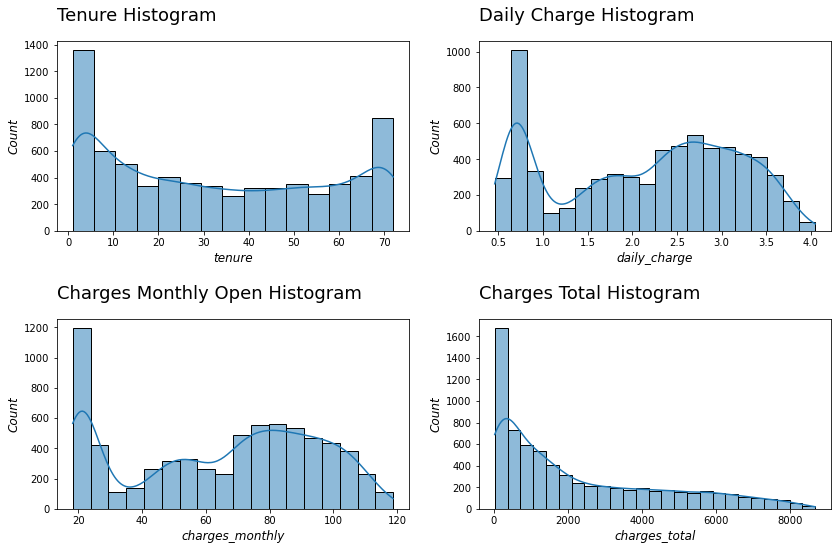

In [185]:
plt.figure(figsize=(12, 8), tight_layout={'pad': 2.0})

plt.subplot(2, 2, 1)
ax1 = sns.histplot(data=num_att, x="tenure", kde=True)
std_font(ax1, 'Tenure Histogram',
         'tenure', 'Count')
plt.subplot(2, 2, 2)
ax2 = sns.histplot(data=num_att, x="daily_charge", kde=True)
std_font(ax2, 'Daily Charge Histogram', 'daily_charge', 'Count')
plt.subplot(2, 2, 3)
ax3 = sns.histplot(data=num_att, x="charges_monthly", kde=True)
std_font(ax3, 'Charges Monthly Open Histogram',
         'charges_monthly', 'Count')
plt.subplot(2, 2, 4)
ax4 = sns.histplot(data=num_att, x="charges_total", kde=True)
std_font(ax4, 'Charges Total Histogram', 'charges_total', 'Count')

# plt.show()

### 6.1.3 Categorical Variable

Dentre as distribuições das variáveis categóricas, notamos um balanceamento na feature gender, além de uma preferência dos clientes por pagamento em electronic check e quea maioria dos clientes estão cadastrados em planos mensais.

In [31]:
cat_att = df_clean.select_dtypes(exclude=['int64', 'float64'])

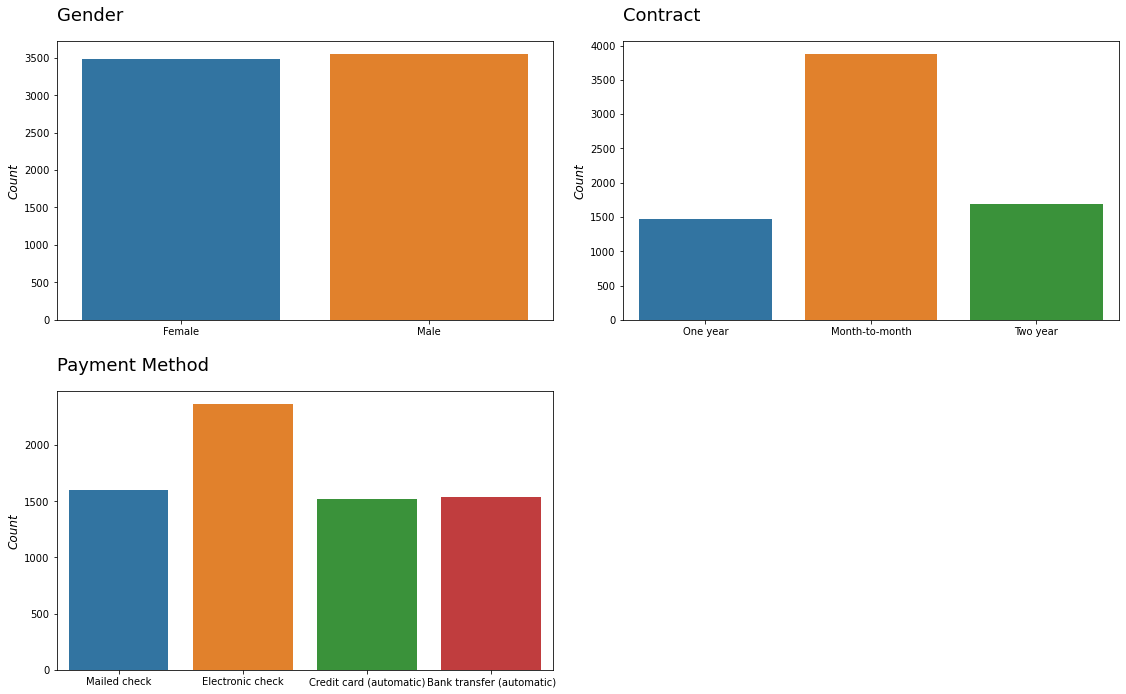

In [211]:
plt.figure(figsize=(16, 10), tight_layout={'pad':2.0})

# gender
plt.subplot( 2, 2, 1 )
ax1 = sns.countplot(x= cat_att['gender'] )
std_font(ax1, 'Gender',
         '', 'Count')

# contract
plt.subplot( 2, 2, 2 )
ax3 = sns.countplot( x=cat_att['contract'] )
std_font(ax3, 'Contract',
         '', 'Count')

# payment_method
plt.subplot( 2, 2, 3 )
ax5 = sns.countplot( x=cat_att['payment_method'] )
std_font(ax5, 'Payment Method',
         '', 'Count')


## 6.2 Bivariate Analysis

### 6.2.1 Quanto mais tempo de contrato o cliente tiver, menor a taxa de churn.

**VERDADEIRO** - Percebemos, de acordo com o gráfico, que quanto maior o tempo de contrato observamos uma tendência de redução na taxa de churn. Além disso, observamos também que a maior taxa de churn estão entre os clientes de até 5 anos. Com esta informação, o time de negócio já consegue tomar ações para reter esses clientes.

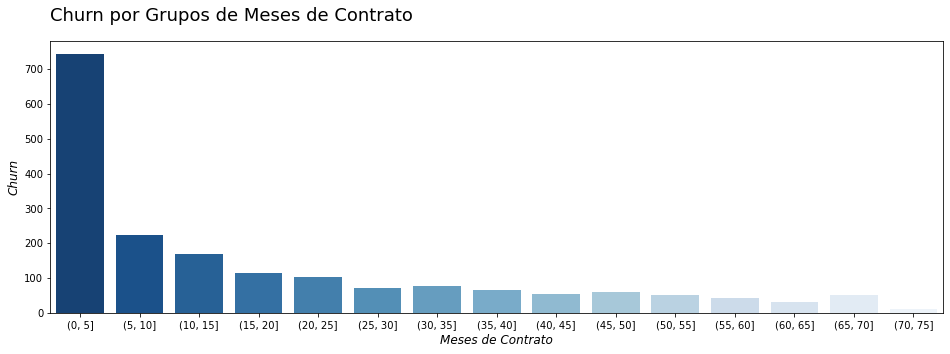

In [217]:
plt.figure(figsize=(16, 5))
bins = list( np.arange( 0, 80, 5) )

# plotando o tenure x tenure
aux = df_clean.query('churn == 1')
aux = aux[['tenure', 'churn']].groupby('tenure').count().reset_index()
aux['tenure_binned'] = pd.cut( aux['tenure'], bins=bins )
aux_bin = aux[['tenure_binned', 'churn']].groupby( 'tenure_binned' ).sum().reset_index()
ax1 = sns.barplot(data=aux_bin, x='tenure_binned', y='churn', palette='Blues_r')
std_font(ax1, 'Churn por Grupos de Meses de Contrato',
         'Meses de Contrato', 'Churn')

### 6.2.2 Mulheres tem maior probabilidade de entrar em churn.

**FALSO** - De acordo com a análise, vemos que dentre os clientes que entraram e churn, homens e mulheres têm a mesma proporção

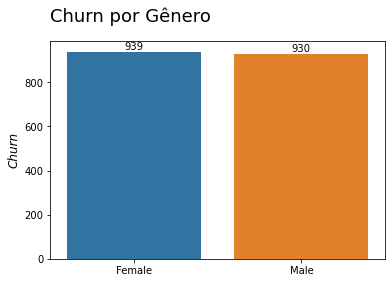

In [194]:
aux = df_clean.query('churn == 1')
aux = aux[['gender', 'churn']].groupby('gender').sum().reset_index()
ax1 = sns.barplot(data=aux, x='gender', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por Gênero',
         '', 'Churn')

### 6.2.3 Clientes com dependentes tendem a ter menor taxa de churn

**VERDADEIRO** - Como podemos ver, 82% dos clientes que entram em churn têm o plano sem dependentes. Com esta informação, o time de negócios já consegue atuar desenvolvendo estratégias para incentivar clientes a aderirem aos planos com dependentes.

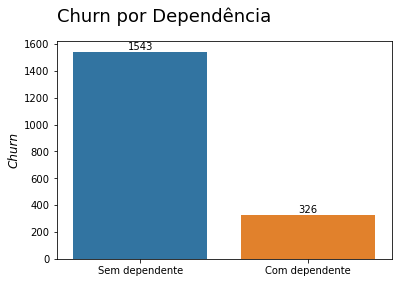

In [198]:
aux = df_clean.query('churn == 1')
aux = aux[['dependents', 'churn']].groupby('dependents').sum().reset_index()
aux['dependents'] = aux['dependents'].map({0: 'Sem dependente', 1:'Com dependente'})
ax1 = sns.barplot(data=aux, x='dependents', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por Dependência',
         '', 'Churn')

### 6.2.4 A maioria dos clientes que entraram em churn não tinham suporte técnico

**VERDADEIRO** - Podemos ver que 83% dos clientes que entraram em churn não tinham suporte técnico. Isso mostra mais uma oportunidade para o time de negócio de tomar ações imediatas para reduzir o número de churn, oferecendo promoções e incentivos para que os clientes adquiram suporte técnico.

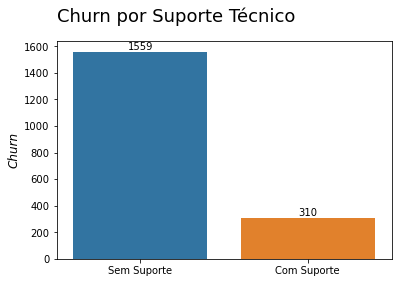

In [191]:
aux = df_clean.query('churn == 1')
aux = aux[['tech_support', 'churn']].groupby('tech_support').sum().reset_index()
aux['tech_support'] = aux['tech_support'].map({0: 'Sem Suporte', 1:'Com Suporte'})
ax1 = sns.barplot(data=aux, x='tech_support', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por Suporte Técnico',
         '', 'Churn')

### 6.2.5 O meio de recebimento da fatura não tem influência na taxa de churn

**FALSO** - Notamos que há uma diferença considerável na taxa de churn, levando em consideração o meio de pagamento. Aqui percebemos algo inesperado: O meio de pagamento digital (que surge como uma proposta para melhorar a experiência do cliente) apresenta quase o triplo de churn em relação ao meio físico. Com essa informação, o time de negócios poderá atuar, junto com demais times, na identificação de problemas ou bugs no serviço de pagamento digital da empresa, visando diminuir esta taxa de churn.

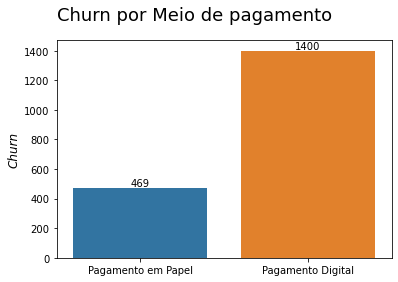

In [192]:
aux = df_clean.query('churn == 1')
aux = aux[['paperless_billing', 'churn']].groupby('paperless_billing').sum().reset_index()
aux['paperless_billing'] = aux['paperless_billing'].map({0: 'Pagamento em Papel', 1:'Pagamento Digital'})
ax1 = sns.barplot(data=aux, x='paperless_billing', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por Meio de pagamento',
         '', 'Churn')

### 6.2.6 Clientes que tem assinatura de tv a cabo tem menores taxas de churn

**FALSO** - Observamos que na verdade os clientes com TV a cabo têm maiores taxas de churn. Porém, esta relação não é tao forte quanto as outras relações já observadas.

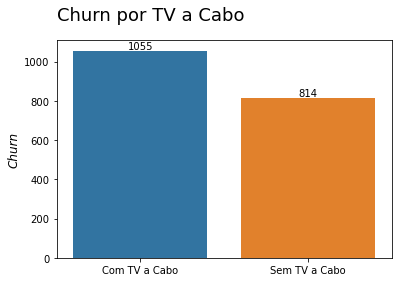

In [193]:
aux = df_clean.query('churn == 1')
aux = aux[['streaming_tv', 'churn']].groupby('streaming_tv').sum().reset_index()
aux['streaming_tv'] = aux['streaming_tv'].map({0: 'Com TV a Cabo', 1:'Sem TV a Cabo'})
ax1 = sns.barplot(data=aux, x='streaming_tv', y='churn')
ax1.bar_label(ax1.containers[0])
std_font(ax1, 'Churn por TV a Cabo',
         '', 'Churn')

### 6.2.7 Clientes com gasto diário de mais de \$3 tendem a ter maior taxa de churn

**FALSO** - Há um pico de taxa de churn entre os valores diários de 2 a 3,5. Para entender este fenômeno, é preciso análises mais profundas junto ao time de negócio.

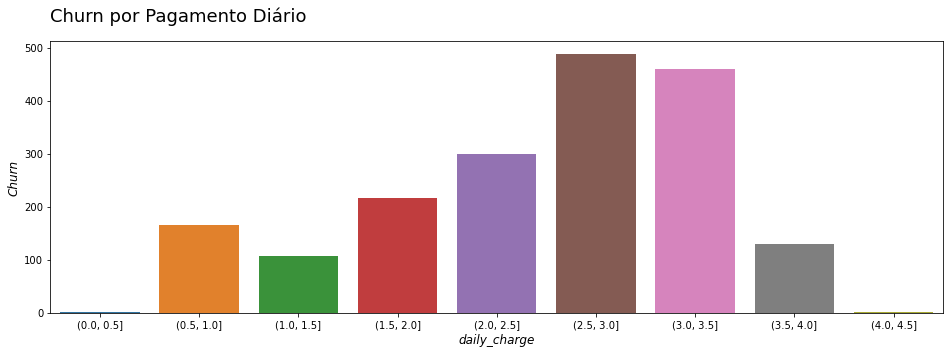

In [196]:
plt.figure(figsize=(16, 5))
bins = list( np.arange( 0, 5, 0.5) )

# plotando o tenure x tenure
aux = df_clean.query('churn == 1')
aux = aux[['daily_charge', 'churn']].groupby('daily_charge').count().reset_index()
aux['daily_binned'] = pd.cut( aux['daily_charge'], bins=bins )
aux_bin = aux[['daily_binned', 'churn']].groupby( 'daily_binned' ).sum().reset_index()
ax1 = sns.barplot(data=aux_bin, x='daily_binned', y='churn')
std_font(ax1, 'Churn por Pagamento Diário',
         'daily_charge', 'Churn')

### 6.2.8 Resumo das hipóteses

In [200]:
tab =[['Hipótese', 'Conclusão', 'Relevância', 'Descoberta'],
      ['H1', 'Verdadeiro', 'Alta', 'Quanto maior o tempo de contrato menor a taxa de churn.'],  
      ['H2', 'Falso', 'Média', 'Dentre os clientes que entraram e churn, homens e mulheres têm a mesma proporção.'],  
      ['H3', 'Verdadeiro', 'Alta', '18% dos clientes que entraram em churn têm dependentes.'],
      ['H4', 'Verdadeiro', 'Alta', '83% dos clientes que entraram em churn não tinham suporte técnico.'],
      ['H5', 'Falso', 'Média', 'Dentre os clientes que entraram em churn, 75% faz uso do pagamento digital.'],
      ['H6', 'Falso', 'Baixa', 'Clientes com TV a cabo têm maiores taxas de churn, porém a diferença é de apenas 23%.'],
      ['H7', 'Falso', 'Baixa', 'Há um pico de taxa de churn entre os valores diários de 2 a 3,5.']    
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipótese    Conclusão    Relevância    Descoberta
----------  -----------  ------------  -------------------------------------------------------------------------------------
H1          Verdadeiro   Alta          Quanto maior o tempo de contrato menor a taxa de churn.
H2          Falso        Média         Dentre os clientes que entraram e churn, homens e mulheres têm a mesma proporção.
H3          Verdadeiro   Alta          18% dos clientes que entraram em churn têm dependentes.
H4          Verdadeiro   Alta          83% dos clientes que entraram em churn não tinham suporte técnico.
H5          Falso        Média         Dentre os clientes que entraram em churn, 75% faz uso do pagamento digital.
H6          Falso        Baixa         Clientes com TV a cabo têm maiores taxas de churn, porém a diferença é de apenas 23%.
H7          Falso        Baixa         Há um pico de taxa de churn entre os valores diários de 2 a 3,5.


## 6.3 Multivariate Analysis


### 6.3.1 Numerical Attributes

 Dentre as variáveis numéricas, podemos observar que não há fortes correlações em relação a variável resposta. Porém, de acordo com a matriz de correlação, as variáveis que apresentaram as maiores correlações foram as variáveis de charge, paperless_billing, internet_service e tenure. Levaremos isso em consideração na hora de definir as features finais para o nosso modelo.

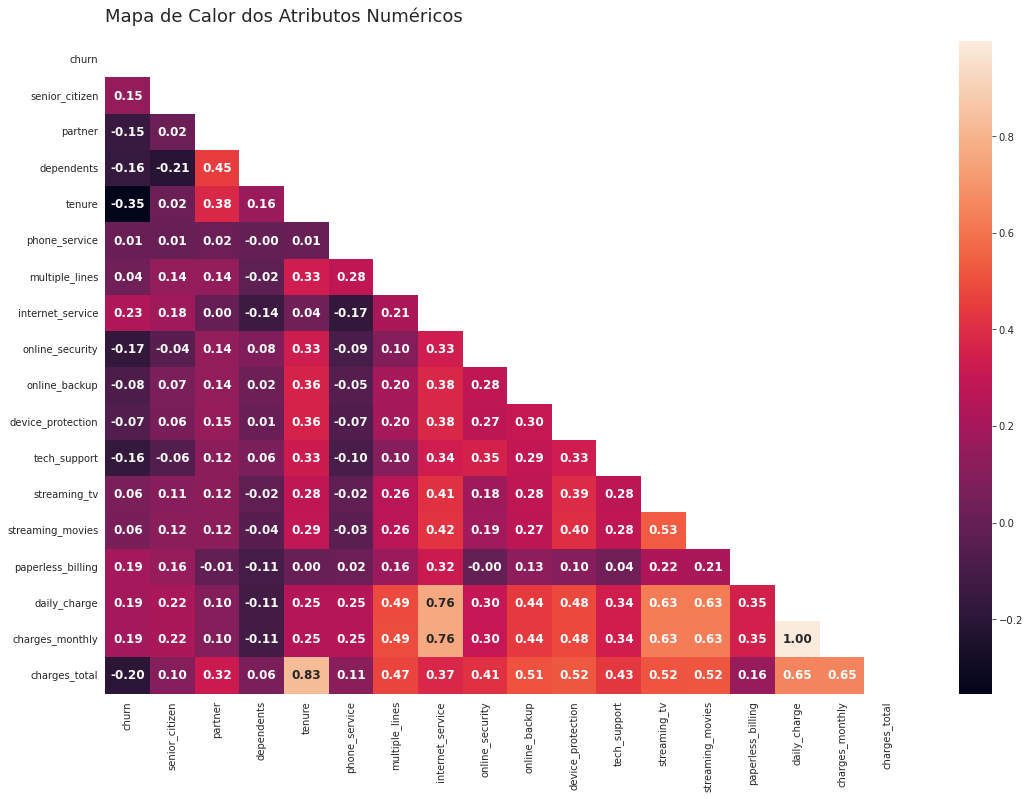

In [212]:
correlation = num_att.corr( method='pearson' )
plt.figure( figsize=(18, 12) )

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax1 = sns.heatmap(data=correlation, annot=True, fmt='.2f', annot_kws={'fontsize':12, 'fontweight':'bold'}, mask=mask)
    std_font(ax1, 'Mapa de Calor dos Atributos Numéricos', '', '')

### 6.3.2 Categorical Attributes

Nesta seção utilizaremos a biblioteca pycorrcat para checar a correlação entre as features categóricas do nosso dataset:

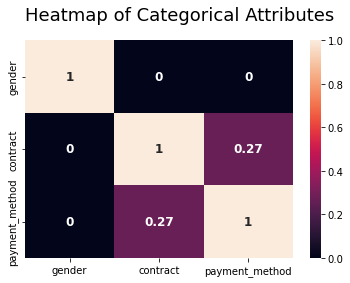

In [22]:
correlation_matrix = corr_matrix(cat_att,columns=['gender', 'contract', 'payment_method'])
ax1 = sns.heatmap(data=correlation_matrix, annot=True, annot_kws={'fontsize':12, 'fontweight':'bold'})
std_font(ax1, 'Heatmap of Categorical Attributes', '', '')

# 7 DATA PREPARATION

## 7.2 Normalization

## 7.3 Rescaling

## 7.4 Transformation

### 7.4.1 Encoding

# 8 FEATURE SELECTION

## 8.1 Split dataframe into training and validation dataset

## 8.3 Selected Features

# 9 MACHINE LEARNING MODELLING

# 10 CROSS-VALIDATION

# 11 HYPERPARAMETER FINE TUNNING

## 11.1 Random Search

## 11.2 Final Model

# 12 BUSINESS PERFORMANCE

# 13 NEXT STEPS